In [24]:
import lightkurve as lk

target = "211.00922 38.618331"
tpf_res = lk.search_targetpixelfile(target, radius=100)
tpf_res

SearchResult containing 0 data products.

In [28]:
import lightkurve as lk

target = "K2-25"
tpf_res = lk.search_targetpixelfile(target)
tpf_res

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,K2 Campaign 04,2015,K2,1800,ktwo210490365,0.0
1,TESS Sector 44,2021,SPOC,120,434226736,0.0
2,TESS Sector 70,2023,SPOC,20,434226736,0.0
3,TESS Sector 71,2023,SPOC,20,434226736,0.0
4,TESS Sector 70,2023,SPOC,120,434226736,0.0
5,TESS Sector 71,2023,SPOC,120,434226736,0.0
6,TESS Sector 44,2021,TESS-SPOC,600,434226736,0.0


In [39]:
tpf = tpf_res[1].download()
tpf.wcs

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 63.27415659532179 15.247670504350861 
CRPIX : 5.660604324038218 5.361089545932259 
PC1_1 PC1_2  : 0.17786862640040882 0.9655291498430361 
PC2_1 PC2_2  : 0.9958163284512322 -0.2165098352082373 
CDELT : -0.005547199839842 0.005547199839842478 
NAXIS : 2448  17466

In [2]:
ls *.fits

tess-s0016-4-4_211.009466_38.618266_50x50_astrocut.fits
tess-s0023-2-2_211.009466_38.618266_50x50_astrocut.fits
tess-s0050-2-2_211.009466_38.618266_50x50_astrocut.fits


In [48]:
tpf.wcs.pixel_to_world(10,20)

<SkyCoord (ICRS): (ra, dec) in deg
    (210.89975669, 38.64438446)>

<Axes: title={'center': 'Target ID: None, Cadence: 1000'}, xlabel='Pixel Column Number', ylabel='Pixel Row Number'>

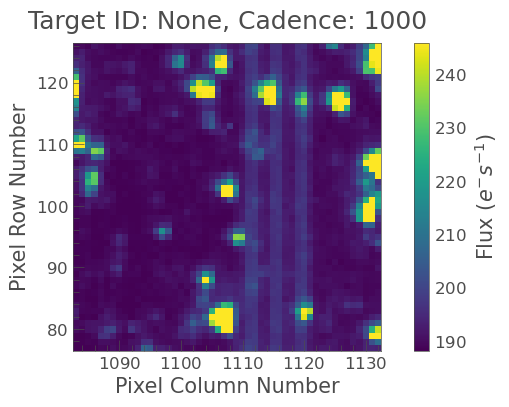

In [42]:
from lightkurve import TessTargetPixelFile

tpf = TessTargetPixelFile('./tess-s0016-4-4_211.009466_38.618266_50x50_astrocut.fits')
# tpf = tpf.cutout(size=(20,20))
tpf.plot(frame=1000)

In [22]:
import numpy as np
import matplotlib.pyplot as pl
from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from astropy.visualization import ZScaleInterval
import astropy.units as u
from astroquery.mast import Catalogs
from scipy.ndimage import zoom

TESS_pix_scale = 21 * u.arcsec  # / u.pixel

# http://gsss.stsci.edu/SkySurveys/Surveys.htm
dss_description = {
    "dss1": "POSS1 Red in the north; POSS2/UKSTU Blue in the south",
    "poss2ukstu_red": "POSS2/UKSTU Red",
    "poss2ukstu_ir": "POSS2/UKSTU Infrared",
    "poss2ukstu_blue": "POSS2/UKSTU Blue",
    "poss1_blue": "POSS1 Blue",
    "poss1_red": "POSS1 Red",
    "all": "best among all plates",
    "quickv": "Quick-V Survey",
    "phase2_gsc2": "HST Phase 2 Target Positioning (GSC 2)",
    "phase2_gsc1": "HST Phase 2 Target Positioning (GSC 1)",
}

def get_dss_data(
    ra,
    dec,
    survey="poss2ukstu_red",
    plot=False,
    height=1,
    width=1,
    epoch="J2000",
):
    """
    Digitized Sky Survey (DSS)
    http://archive.stsci.edu/cgi-bin/dss_form
    Parameters
    ----------
    survey : str
        (default=poss2ukstu_red) see `dss_description`
    height, width : float
        image cutout height and width [arcmin]
    epoch : str
        default=J2000
    Returns
    -------
    hdu
    """
    survey_list = list(dss_description.keys())
    if survey not in survey_list:
        raise ValueError(f"{survey} not in:\n{survey_list}")
    base_url = "http://archive.stsci.edu/cgi-bin/dss_search?v="
    url = f"{base_url}{survey}&r={ra}&d={dec}&e={epoch}&h={height}&w={width}"
    url += "&f=fits&c=none&s=on&fov=NONE&v3"
    try:
        hdulist = fits.open(url)
        # hdulist.info()

        hdu = hdulist[0]
        # data = hdu.data
        # header = hdu.header
        if plot:
            _ = plot_dss_image(hdu)
        return hdu
    except Exception as e:
        if isinstance(e, OSError):
            print(f"Error: {e}\nsurvey={survey} image is likely unavailable.")
        else:
            raise Exception(f"Error: {e}")

def plot_dss_image(
    hdu, cmap="gray", contrast=0.5, coord_format="dd:mm:ss", ax=None
):
    """
    Plot output of get_dss_data:
    hdu = get_dss_data(ra, dec)
    """
    data, header = hdu.data, hdu.header
    interval = ZScaleInterval(contrast=contrast)
    zmin, zmax = interval.get_limits(data)

    if ax is None:
        fig = pl.figure(constrained_layout=True)
        ax = fig.add_subplot(projection=WCS(header))
    ax.imshow(data, vmin=zmin, vmax=zmax, cmap=cmap)
    ax.set_xlabel("RA")
    ax.set_ylabel("DEC", y=0.9)
    title = f"{header['SURVEY']} ({header['FILTER']})\n"
    title += f"{header['DATE-OBS'][:10]}"
    ax.set_title(title)
    # set RA from hourangle to degree
    if hasattr(ax, "coords"):
        ax.coords[1].set_major_formatter(coord_format)
        ax.coords[0].set_major_formatter(coord_format)
    return ax
    
def plot_gaia_sources_on_survey(
    tpf,
    target_gaiaid,
    hdu=None,
    gaia_sources=None,
    fov_rad=None,
    depth=0.0,
    kmax=1.0,
    sap_mask="pipeline",
    survey="dss1",
    ax=None,
    color_aper="C0",  # pink
    figsize=None,
    invert_xaxis=False,
    invert_yaxis=False,
    pix_scale=TESS_pix_scale,
    verbose=True,
    **mask_kwargs,
):
    """Plot (superpose) Gaia sources on archival image

    Parameters
    ----------
    target_coord : astropy.coordinates
        target coordinate
    gaia_sources : pd.DataFrame
        gaia sources table
    fov_rad : astropy.unit
        FOV radius
    survey : str
        image survey
    verbose : bool
        print texts
    ax : axis
        subplot axis
    color_aper : str
        aperture outline color (default=C6)
    kwargs : dict
        keyword arguments for aper_radius, percentile
    Returns
    -------
    ax : axis
        subplot axis

    TODO: correct for proper motion difference between
    survey image and gaia DR2 positions
    """
    errmsg = f"{survey} not in {list(dss_description.keys())}"
    assert survey in list(dss_description.keys()), errmsg
    if verbose:
        print("Plotting nearby gaia sources on survey image.")
    assert target_gaiaid is not None
    ny, nx = tpf.flux.shape[1:]
    if fov_rad is None:
        diag = np.sqrt(nx**2 + ny**2)
        fov_rad = (0.4 * diag * pix_scale).to(u.arcmin).round(2)
    target_coord = SkyCoord(ra=tpf.ra * u.deg, dec=tpf.dec * u.deg)
    if gaia_sources is None:
        print("Querying Gaia sources around the target.")
        gaia_sources = Catalogs.query_region(
            target_coord, radius=fov_rad, catalog="Gaia", version=2
        ).to_pandas()
    assert len(gaia_sources) > 1, "gaia_sources contains single entry"
    # make aperture mask
    mask = parse_aperture_mask(tpf, sap_mask=sap_mask, **mask_kwargs)
    maskhdr = tpf.hdu[2].header
    # make aperture mask outline
    contour = np.zeros((ny, nx))
    contour[np.where(mask)] = 1
    contour = np.lib.pad(contour, 1, PadWithZeros)
    highres = zoom(contour, 100, order=0, mode="nearest")
    extent = np.array([-1, nx, -1, ny])

    if verbose:
        print(
            f"Querying {survey} ({fov_rad:.2f} x {fov_rad:.2f}) archival image"
        )
    # -----------create figure---------------#
    if (ax is None) or (hdu is None):
        # get img hdu for subplot projection
        try:
            hdu = get_dss_data(
                ra=target_coord.ra.deg,
                dec=target_coord.dec.deg,
                survey=survey,
                width=fov_rad.value,
                height=fov_rad.value,
            )
        except Exception:
            errmsg = "survey image not available"
            raise FileNotFoundError(errmsg)
        fig = pl.figure(figsize=figsize)
        # define scaling in projection
        ax = fig.add_subplot(111, projection=WCS(hdu.header))
    # plot survey img
    ax.imshow(hdu.data, cmap="Greys", origin="lower")
    ax.set(xlabel="RA", ylabel="DEC")
    imgwcs = WCS(hdu.header)
    mx, my = hdu.data.shape
    # plot mask
    _ = ax.contour(
        highres,
        levels=[0.5],
        extent=extent,
        origin="lower",
        linewidths=[3],
        colors=color_aper,
        transform=ax.get_transform(WCS(maskhdr)),
    )
    idx = gaia_sources["source_id"].astype(int).isin([target_gaiaid])
    target_gmag = gaia_sources.loc[idx, "phot_g_mean_mag"].values[0]

    for _, row in gaia_sources.iterrows():
        marker, s = "o", 100
        r, d, mag, id = row[["ra", "dec", "phot_g_mean_mag", "source_id"]]
        pix = imgwcs.all_world2pix(np.c_[r, d], 1)[0]
        if int(id) != int(target_gaiaid):
            gamma = 1 + 10 ** (0.4 * (mag - target_gmag))
            if depth > kmax / gamma:
                # too deep to have originated from secondary star
                edgecolor = "C1"
                alpha = 1  # 0.5
            else:
                # possible NEBs
                edgecolor = "C3"
                alpha = 1
        else:
            s = 200
            edgecolor = "C2"
            marker = "s"
            alpha = 1
        ax.scatter(
            pix[0],
            pix[1],
            marker=marker,
            s=s,
            edgecolor=edgecolor,
            alpha=alpha,
            facecolor="none",
        )
    # orient such that north is up; left is east
    if invert_yaxis:
        # ax.invert_yaxis()
        raise NotImplementedError()
    if invert_xaxis:
        # ax.invert_xaxis()
        raise NotImplementedError()
    if hasattr(ax, "coords"):
        ax.coords[0].set_major_formatter("dd:mm")
        ax.coords[1].set_major_formatter("dd:mm")
    # set img limits
    pl.setp(
        ax,
        xlim=(0, mx),
        ylim=(0, my),
    )
    ax.set_title(
        f"{survey} ({fov_rad.value:.2f}' x {fov_rad.value:.2f}')", y=0.99
    )
    return ax

def parse_aperture_mask(
    tpf,
    sap_mask="pipeline",
    aper_radius=None,
    percentile=None,
    verbose=False,
    threshold_sigma=None,
):
    """Parse and make aperture mask"""
    if verbose:
        if sap_mask == "round":
            print(
                "aperture photometry mask: {} (r={} pix)\n".format(
                    sap_mask, aper_radius
                )
            )
        elif sap_mask == "square":
            print(
                "aperture photometry mask: {0} ({1}x{1} pix)\n".format(
                    sap_mask, aper_radius
                )
            )
        elif sap_mask == "percentile":
            print(
                "aperture photometry mask: {} ({}%)\n".format(
                    sap_mask, percentile
                )
            )
        else:
            print("aperture photometry mask: {}\n".format(sap_mask))

    median_img = np.nanmedian(tpf.flux, axis=0).value
    if (sap_mask == "pipeline") or (sap_mask is None):
        errmsg = "tpf does not have pipeline mask"
        assert tpf.pipeline_mask is not None, errmsg
        mask = tpf.pipeline_mask  # default
    elif sap_mask == "all":
        mask = np.ones((tpf.shape[1], tpf.shape[2]), dtype=bool)
    elif sap_mask == "round":
        assert aper_radius is not None, "supply aper_radius"
        mask = make_round_mask(median_img, radius=aper_radius)
    elif sap_mask == "square":
        assert aper_radius is not None, "supply aper_radius/size"
        mask = make_square_mask(median_img, size=aper_radius)
    elif sap_mask == "threshold":
        assert threshold_sigma is not None, "supply threshold_sigma"
        # FIXME: make sure aperture is contiguous
        mask = tpf.create_threshold_mask(threshold_sigma)
    elif sap_mask == "percentile":
        assert percentile is not None, "supply percentile"
        mask = median_img > np.nanpercentile(median_img, percentile)
    else:
        raise ValueError("Unknown aperture mask")
    return mask


def make_round_mask(img, radius, xy_center=None):
    """Make round mask in units of pixels

    Parameters
    ----------
    img : numpy ndarray
        image
    radius : int
        aperture mask radius or size
    xy_center : tuple
        aperture mask center position

    Returns
    -------
    mask : np.ma.masked_array
        aperture mask
    """
    offset = 2  # from center
    xcen, ycen = img.shape[0] // 2, img.shape[1] // 2
    if xy_center is None:  # use the middle of the image
        y, x = np.unravel_index(np.argmax(img), img.shape)
        xy_center = [x, y]
        # check if near edge
        if np.any([abs(x - xcen) > offset, abs(y - ycen) > offset]):
            print("Brightest star is detected far from the center.")
            print("Aperture mask is placed at the center instead.\n")
            xy_center = [xcen, ycen]

    Y, X = np.ogrid[: img.shape[0], : img.shape[1]]
    dist_from_center = np.sqrt(
        (X - xy_center[0]) ** 2 + (Y - xy_center[1]) ** 2
    )

    mask = dist_from_center <= radius
    return np.ma.masked_array(img, mask=mask).mask


def make_square_mask(img, size, xy_center=None):
    """Make rectangular mask with optional rotation

    Parameters
    ----------
    img : numpy ndarray
        image
    size : int
        aperture mask size
    xy_center : tuple
        aperture mask center position
    angle : int
        rotation

    Returns
    -------
    mask : np.ma.masked_array
        aperture mask
    """
    offset = 2  # from center
    xcen, ycen = img.shape[0] // 2, img.shape[1] // 2
    if xy_center is None:  # use the middle of the image
        y, x = np.unravel_index(np.argmax(img), img.shape)
        xy_center = [x, y]
        # check if near edge
        if np.any([abs(x - xcen) > offset, abs(y - ycen) > offset]):
            print("Brightest star detected is far from the center.")
            print("Aperture mask is placed at the center instead.\n")
            xy_center = [xcen, ycen]
    mask = np.zeros_like(img, dtype=bool)
    mask[
        ycen - size : ycen + size + 1, xcen - size : xcen + size + 1
    ] = True
    return mask

def PadWithZeros(vector, pad_width, iaxis, kwargs):
    vector[: pad_width[0]] = 0  # noqa
    vector[-pad_width[1] :] = 0  # noqa
    return vector

Plotting nearby gaia sources on survey image.
Querying Gaia sources around the target.
Querying all (9.90 arcmin x 9.90 arcmin) archival image


ValueError: Expected 2 world coordinates, got 0 

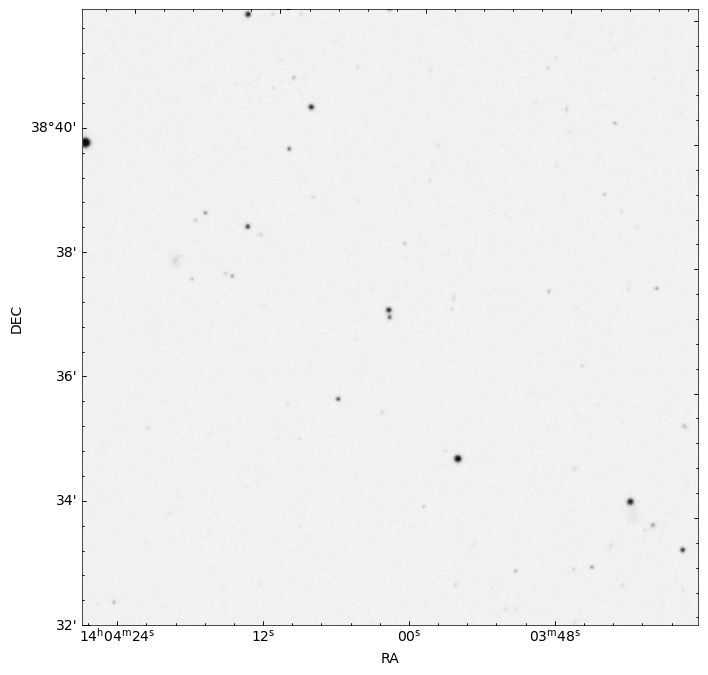

In [23]:
from aesthetic.plot import set_style, savefig
set_style('science')

ax = plot_gaia_sources_on_survey(tpf,
                                 sap_mask="pipeline",
                                 target_gaiaid=3311804515502788352,
                                 survey='all',                                 
                                 depth=81180/1e6,  #ppm
                                 color_aper='C0',
                                 figsize=(8,8)
                                )
ax.set_title(f'TESS sector {tpf.sector} on POSS archival image')
if False:
    savefig(ax.figure, 'K2-25.pdf', dpi=300, writepdf=False)